In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error


In [45]:
df = pd.read_csv("../data/processed/final_training_data.csv")

# Quick look
df.head()

# Basic info
df.info()

# Check for nulls
df.isnull().sum()

/var/folders/px/j7p2_nnn6h339lc16xg05qbw0000gn/T/ipykernel_19397/2739705867.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/final_training_data.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528625 entries, 0 to 528624
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   requestid            528625 non-null  int64  
 1   boro                 528625 non-null  object 
 2   year                 528625 non-null  int64  
 3   month                528625 non-null  int64  
 4   day                  528625 non-null  int64  
 5   hour                 528625 non-null  int64  
 6   minute               528625 non-null  int64  
 7   vol                  528625 non-null  int64  
 8   segmentid            528625 non-null  int64  
 9   wktgeom              528625 non-null  object 
 10  street               528625 non-null  object 
 11  fromst               528625 non-null  object 
 12  tost                 528625 non-null  object 
 13  direction            528625 non-null  object 
 14  timestamp            528625 non-null  object 
 15  dayofweek        

requestid                   0
boro                        0
year                        0
month                       0
day                         0
hour                        0
minute                      0
vol                         0
segmentid                   0
wktgeom                     0
street                      0
fromst                      0
tost                        0
direction                   0
timestamp                   0
dayofweek                   0
is_weekend                  0
is_rush_hour                0
is_holiday                  0
holiday_name           510289
holiday_type           510289
is_holiday_period           0
temperature_2m              0
precipitation               0
weathercode                 0
windspeed_10m               0
weather_description         0
dtype: int64

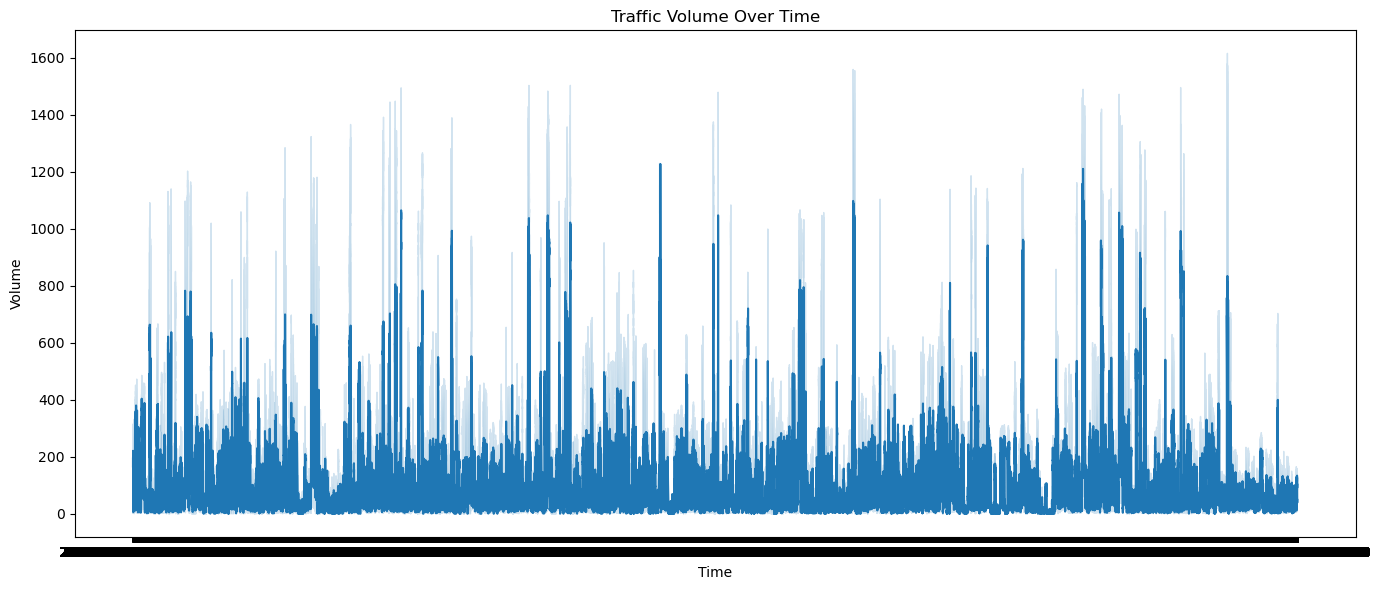

In [28]:
# Line Plot: Volume Over Time
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='timestamp', y='vol')
plt.title("Traffic Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

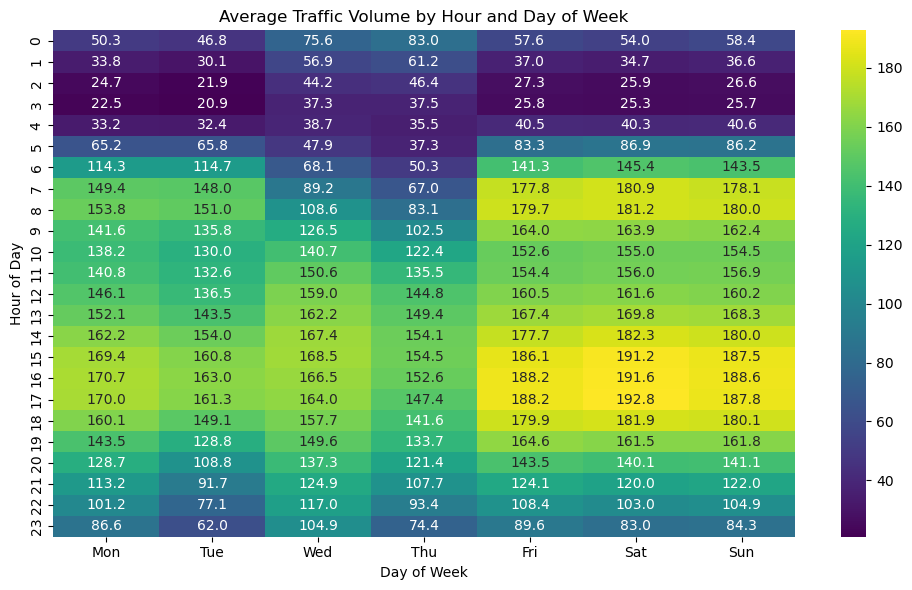

In [ ]:
# Heatmap: Hour vs Day of Week

# Pivot table: rows=hour, columns=dayofweek, values=mean volume
pivot = df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')

# Rename columns from 0–6 to weekday names
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

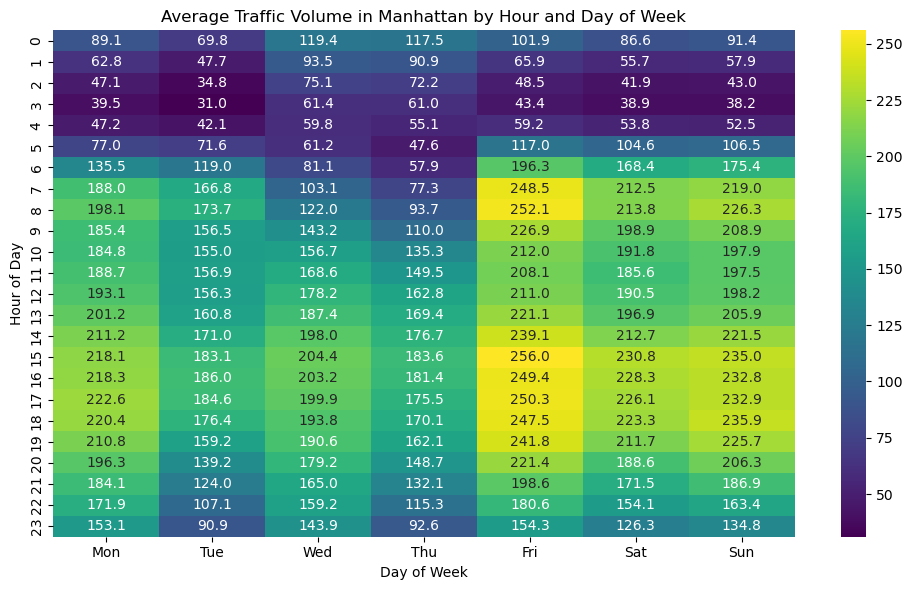

In [30]:
# Heatmap by bourough (ex. Manhattan)
manhattan_df = df[df['boro'] == 'Manhattan']

# Then pivot just like before
pivot = manhattan_df.pivot_table(index='hour', columns='dayofweek', values='vol', aggfunc='mean')
pivot.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title("Average Traffic Volume in Manhattan by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

In [ ]:
# Drop irrelevant columns
df = df.drop(columns=[
    'requestid', 'wktgeom', 'street', 'fromst', 'tost', 
    'holiday_name', 'holiday_type', 'timestamp', 'weather_description'
])

# Drop rows with missing values if any
df = df.dropna()

# Target variable
y = df['vol']

# Features
X = df.drop(columns='vol')

# Categorical features to one-hot encode
categorical_features = ['boro', 'direction', 'dayofweek']
numerical_features = [
    'year', 'month', 'day', 'hour', 'minute',
    'is_weekend', 'is_rush_hour',
    'is_holiday', 'is_holiday_period',
    'temperature_2m', 'precipitation',
    'weathercode', 'windspeed_10m'
]

In [47]:
# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # leave the numerical columns as they are
)

# Create pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

In [48]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

In [50]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 11.80
RMSE: 22.53
R²: 0.9840


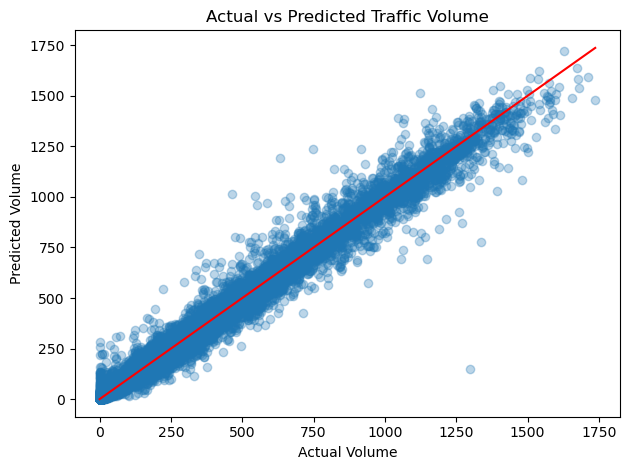

In [51]:
# Check for bias

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Actual vs Predicted Traffic Volume")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.tight_layout()
plt.show()

In [52]:
# Evaluate using 5-fold cross-validation
cv_scores = cross_val_score(
    pipeline, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Use RMSE directly
    n_jobs=-1
)

# Convert negative scores to positive RMSE
rmse_scores = -cv_scores

print("Cross-Validated RMSE scores:", rmse_scores)
print("Mean RMSE: {:.2f}".format(np.mean(rmse_scores)))
print("Standard Deviation: {:.2f}".format(np.std(rmse_scores)))

Cross-Validated RMSE scores: [147.90400801 174.1636247  151.72160679 138.50235101 160.0500918 ]
Mean RMSE: 154.47
Standard Deviation: 12.04
